<a href="https://colab.research.google.com/github/akd18/DS-SL/blob/main/Income%20Qualification%20Project/Income_Qualification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train_data_raw = pd.read_csv('https://raw.githubusercontent.com/akd18/DS-SL/main/Income%20Qualification%20Project/train.csv')
test_data_raw = pd.read_csv('https://raw.githubusercontent.com/akd18/DS-SL/main/Income%20Qualification%20Project/test.csv')
train_data_raw.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,...,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,...,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [3]:
test_data_raw.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,...,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,0,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,17,16.5,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,16,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,17,16.5,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,17,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,17,16.5,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,16,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,no,16.0,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11,NaN,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.25,64.00,NaN,324


- The test data doesnt have a label, therefore it cannot to used for model evaluation or testing. 

We will have to split the given training set to train-test split.

In [4]:
pd.set_option('display.max_rows',200)
pd.set_option('display.max_colwidth', 500)

In [5]:
pd.options.mode.chained_assignment = None

We have a document describing the features of the dataset. We shall try to extract this data into a Series for easier access within the notebook.

In [6]:
!pip install -q PyMuPDF

In [7]:
import urllib
import fitz
import re

In [8]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/akd18/DS-SL/main/Income%20Qualification%20Project/Income%20Qualification%20Feature%20Description.pdf','document.pdf')

('document.pdf', <http.client.HTTPMessage at 0x7fe61c3f3750>)

In [9]:
doc = fitz.open('document.pdf') 
doc

Document('document.pdf')

In [10]:
feature,desc = [],[]

for i in range(doc.page_count):
  page = doc.load_page(i)
  text = page.get_text()
  text_list = re.split(r'[*0-9]*\.', text)
  text_list = [x.replace('\n','').strip() for x in text_list]
  text_list = [re.split(r',', x, maxsplit=1) for x in text_list]
  descr_list = [[x[0].split('=')[0]]+x if len(x)<2 else x for x in text_list]
  descr_list = descr_list[1:]

  feature.extend([x[0].strip() for x in descr_list])
  desc.extend([x[1].strip() for x in descr_list])

feature[0] = 'Id'
col_descr = pd.Series(index=feature,data=desc)
col_descr

Id                                                                                                                                                          ID = Unique ID
v2a1                                                                                                                                                  Monthly rent payment
hacdor                                                                                                                                         =1 Overcrowding by bedrooms
rooms                                                                                                                                     number of all rooms in the house
hacapo                                                                                                                                            =1 Overcrowding by rooms
v14a                                                                                                                                      =1 has 

- We have now created a Series object describing the columns/features of the dataset.

In [11]:
# Example
col_descr['SQBmeaned']

'square of the mean years of education of adults (>=18) in the household'

# Analysing the Data

In [12]:
train_data_raw.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Data columns (total 143 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               9557 non-null   object 
 1   v2a1             2697 non-null   float64
 2   hacdor           9557 non-null   int64  
 3   rooms            9557 non-null   int64  
 4   hacapo           9557 non-null   int64  
 5   v14a             9557 non-null   int64  
 6   refrig           9557 non-null   int64  
 7   v18q             9557 non-null   int64  
 8   v18q1            2215 non-null   float64
 9   r4h1             9557 non-null   int64  
 10  r4h2             9557 non-null   int64  
 11  r4h3             9557 non-null   int64  
 12  r4m1             9557 non-null   int64  
 13  r4m2             9557 non-null   int64  
 14  r4m3             9557 non-null   int64  
 15  r4t1             9557 non-null   int64  
 16  r4t2             9557 non-null   int64  
 17  r4t3         

- Few columns have null/missing values and most of the features are of numeric datatype.

Before any further analysis, we shall split the dataset for training and testing, and set the test dataset aside.

In [13]:
train_data = train_data_raw.copy()
pred_data = test_data_raw.copy()

In [14]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train_data,test_size=0.2, stratify=train_data['Target'], random_state=21)

In [15]:
train_set = train.copy()

In [16]:
train['Target'].value_counts()

4    4796
2    1278
3     967
1     604
Name: Target, dtype: int64

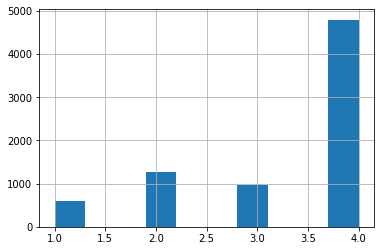

In [17]:
train['Target'].hist()

- We can see that the dataset is heavily biased to the target category '4' which constitutes for more than half of the data.

In [18]:
non_binary_variables = train.nunique()[train.nunique()>2].index
non_binary_variables

Index(['Id', 'v2a1', 'rooms', 'v18q1', 'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2',
       'r4m3', 'r4t1', 'r4t2', 'r4t3', 'tamhog', 'tamviv', 'escolari',
       'rez_esc', 'hhsize', 'idhogar', 'hogar_nin', 'hogar_adul',
       'hogar_mayor', 'hogar_total', 'dependency', 'edjefe', 'edjefa',
       'meaneduc', 'bedrooms', 'overcrowding', 'qmobilephone', 'age',
       'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin',
       'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq', 'Target'],
      dtype='object')

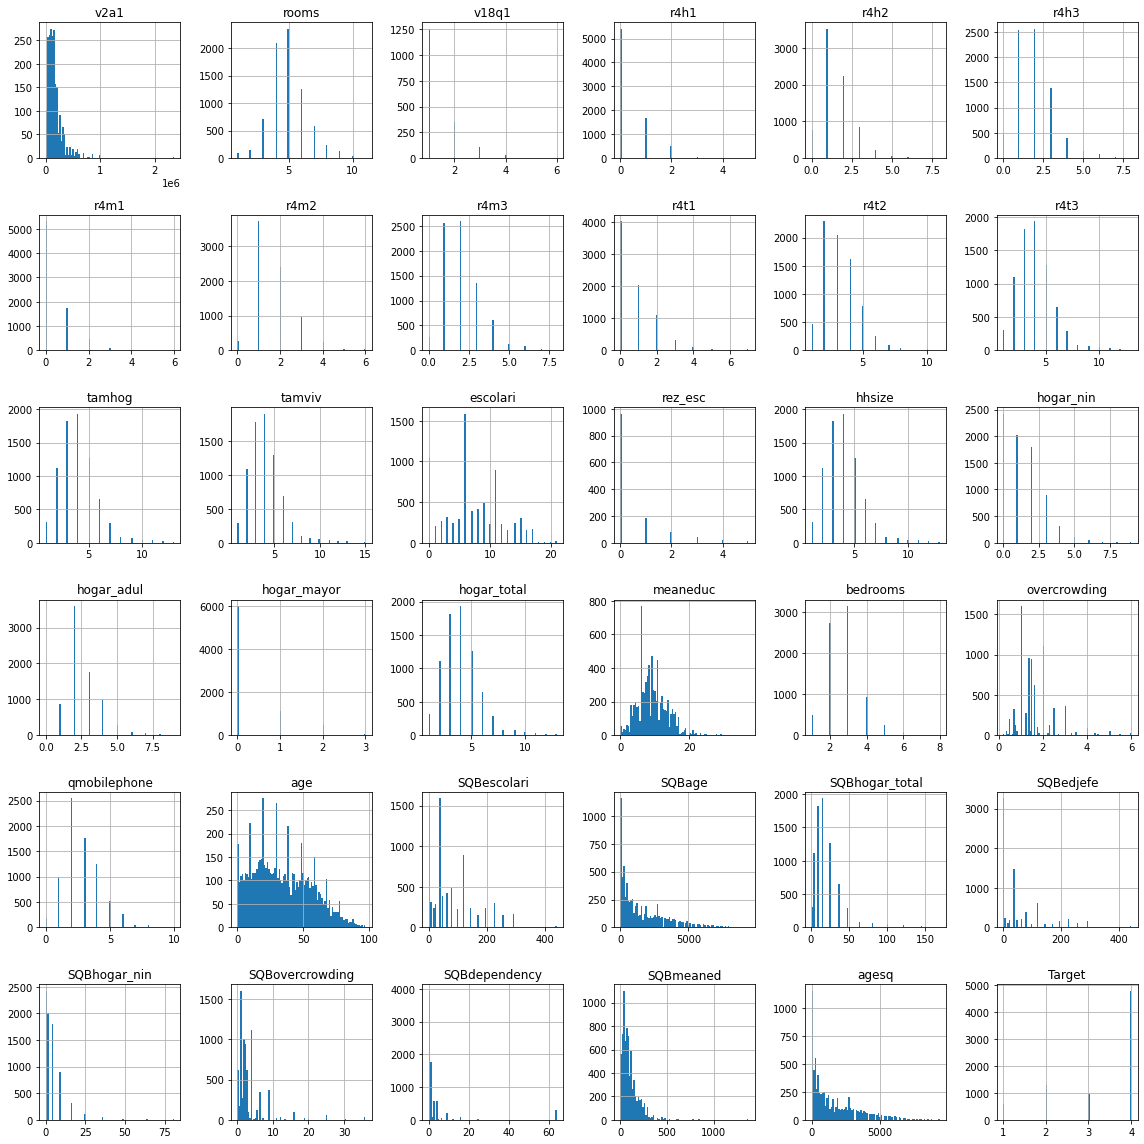

In [19]:
train.hist(column=non_binary_variables , bins=round(np.sqrt(len(train))),figsize=(16,16))
plt.tight_layout()

- As we can see most features are of descrete type with very few exceptions.

### Missing Values

We will now try to find missing values in the dataset.

In [20]:
def missing_count(train):
  print("Number of Instances : ",len(train))
  print("Number of Missing Values in :")
  for feature in train.columns:
    if train[feature].isna().sum()>0:
      print(f"  - {feature} :", train[feature].isna().sum(),f"({train[feature].isna().sum()*100/len(train):0.2f} %)")

In [21]:
missing_count(train)

Number of Instances :  7645
Number of Missing Values in :
  - v2a1 : 5459 (71.41 %)
  - v18q1 : 5895 (77.11 %)
  - rez_esc : 6346 (83.01 %)
  - meaneduc : 5 (0.07 %)
  - SQBmeaned : 5 (0.07 %)


- More than 70% of the data is missing in some columns.

In [22]:
def col_descriptions(col_names):
  ''' col_descriptions() accepts 1 argument, 'String'/'List-like String' '''
  col_names=list(col_names)
  for x in col_names:
    print(x," : ",col_descr[x])

In [23]:
col_descriptions(['v2a1','v18q1','rez_esc','meaneduc','SQBmeaned'])

v2a1  :  Monthly rent payment
v18q1  :  number of tablets household owns
rez_esc  :  Years behind in school
meaneduc  :  average years of education for adults (18+)
SQBmeaned  :  square of the mean years of education of adults (>=18) in the household


- The column 'v2a1' refers to Rent Payment, not all houses could be rented, we have to check that.
- We could also try to find if these missing values are MCAR(Missing Completely At Random), MAR(Missing At Random) or MNAR(Missing Not At Random).

1.  We shall try to find if there is any relation between the missing values in 
'v2a1'(Monthly Rent) and the type of house ownership.

In [24]:
col_descriptions(['tipovivi1','tipovivi2','tipovivi3','tipovivi4','tipovivi5'])

tipovivi1  :  =1 own and fully paid house
tipovivi2  :  "=1 own,  paying in installments"
tipovivi3  :  =1 rented
tipovivi4  :  =1 precarious
tipovivi5  :  "=1 other(assigned,  borrowed)"


In [25]:
train[train.v2a1.isna()][['tipovivi1','tipovivi2','tipovivi3','tipovivi4','tipovivi5']].sum()

tipovivi1    4705
tipovivi2       0
tipovivi3       0
tipovivi4     119
tipovivi5     635
dtype: int64

- We can see that NANs in column 'v2a1' actually are because the house is either 'own and fully paid house', 'precarious' or 'other(assigned,  borrowed)'.

NANs in this case can be replaced by 0.

In [26]:
train.loc[:,['v2a1']] = train.v2a1.fillna(0)
train.v18q1.isna().sum()

5895

2.  We shall try to find if there is any relation/pattern between the missing values in 'v18q1'

In [27]:
train.v18q1.unique()

array([ 1., nan,  3.,  2.,  4.,  5.,  6.])

In [28]:
col_descr[col_descr.str.contains('tablet',case = False)]

v18q                        owns a tablet
v18q1    number of tablets household owns
dtype: object

In [29]:
train.v18q[train.v18q1.isna()].sum()

0

- As we can see, both the columns 'v18q' and 'v18q1' conveys the same information where NAN in 'v18q1' being the same as 0 in 'v18q'.

NANs in 'v18q1' represents owning 0 tablets. NANs should be replaced by 0.

In [30]:
train.loc[:,['v18q1']] = train.v18q1.fillna(0)
train.v18q1.isna().sum()

0

3.  Now we shall try to find if there is any relation/pattern between the missing values in 'rez_esc'

In [31]:
train.rez_esc.unique()

array([nan,  0.,  2.,  1.,  3.,  4.,  5.])

In [32]:
col_descr[col_descr.str.contains('school|edu|age|acad',case = False)]

r4h1                                                                                                                               Males younger than 12 years of age
r4h2                                                                                                                                  Males 12 years of age and older
r4m1                                                                                                                             Females younger than 12 years of age
r4m2                                                                                                                                Females 12 years of age and older
r4t1                                                                                                                             persons younger than 12 years of age
r4t2                                                                                                                                persons 12 years of age and older
esco

In [33]:
train[train.rez_esc.isna()].escolari.value_counts()

6     1400
0      949
11     878
9      395
15     300
8      291
14     245
7      235
12     235
3      208
10     179
5      168
17     165
13     155
16     152
4      137
2      128
1       91
21      17
19       8
18       6
20       4
Name: escolari, dtype: int64

In [34]:
col_descriptions(['instlevel1', 'instlevel2','instlevel3','instlevel4','instlevel5','instlevel6','instlevel7','instlevel8','instlevel9'])

instlevel1  :  =1 no level of education
instlevel2  :  =1 incomplete primary
instlevel3  :  =1 complete primary
instlevel4  :  =1 incomplete academic secondary level
instlevel5  :  =1 complete academic secondary level
instlevel6  :  =1 incomplete technical secondary level
instlevel7  :  =1 complete technical secondary level
instlevel8  :  =1 undergraduate and higher education
instlevel9  :  =1 postgraduate higher education


In [35]:
train[train.rez_esc.isna()][['instlevel1', 'instlevel2','instlevel3','instlevel4','instlevel5','instlevel6','instlevel7','instlevel8','instlevel9']].sum()

instlevel1     932
instlevel2     743
instlevel3    1400
instlevel4    1066
instlevel5     852
instlevel6      62
instlevel7     115
instlevel8    1055
instlevel9     119
dtype: int64

- The column 'rez_esc' (Years behind in school), had more than 83% of its values missing and seems to be Missing Completly At Random(MCAR) since we couldnt find any valid relation/pattern.

We should drop this column.

In [36]:
train.drop(columns='rez_esc',inplace=True)
train.shape

(7645, 142)

4.  Now we shall try to find if there is any relation/pattern between the missing values in 'meaneduc' and 'SQBmeaned'.

In [37]:
train.meaneduc[train.SQBmeaned.isna()]

2050   NaN
1291   NaN
2049   NaN
1840   NaN
1841   NaN
Name: meaneduc, dtype: float64

In [38]:
(train.meaneduc==0).sum()

54

In [39]:
col_descr[col_descr.str.contains('school|edu|age|acad',case = False)].index

Index(['r4h1', 'r4h2', 'r4m1', 'r4m2', 'r4t1', 'r4t2', 'escolari', 'rez_esc',
       'edjefe', 'edjefa', 'meaneduc', 'instlevel1', 'instlevel4',
       'instlevel5', 'instlevel8', 'instlevel9', 'age', 'SQBage', 'SQBmeaned',
       'agesq'],
      dtype='object')

In [40]:
train[train.meaneduc.isna()].loc[:,['r4h1', 'r4h2', 'r4m1', 'r4m2', 'r4t1', 'r4t2', 'escolari', 'edjefe', 'edjefa', 'meaneduc', 'instlevel1', 'instlevel4',
                                    'instlevel5', 'instlevel8', 'instlevel9', 'age', 'SQBage', 'SQBmeaned', 'agesq']]

,r4h1,r4h2,r4m1,r4m2,r4t1,r4t2,escolari,edjefe,edjefa,meaneduc,instlevel1,instlevel4,instlevel5,instlevel8,instlevel9,age,SQBage,SQBmeaned,agesq
2050,0,2,0,0,0,2,12,12,no,NaN,0,0,0,0,0,19,361,NaN,361
1291,0,0,0,1,0,1,10,no,10,NaN,0,1,0,0,0,18,324,NaN,324
2049,0,2,0,0,0,2,12,12,no,NaN,0,0,0,0,0,19,361,NaN,361
1840,0,1,0,1,0,2,6,4,no,NaN,0,0,0,0,0,18,324,NaN,324
1841,0,1,0,1,0,2,4,4,no,NaN,0,0,0,0,0,18,324,NaN,324


In [41]:
train[train.meaneduc.isna()].loc[:,['instlevel1', 'instlevel2','instlevel3','instlevel4','instlevel5','instlevel6','instlevel7','instlevel8','instlevel9']]

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
2050,0,0,0,0,0,0,1,0,0
1291,0,0,0,1,0,0,0,0,0
2049,0,0,0,0,0,0,1,0,0
1840,0,0,1,0,0,0,0,0,0
1841,0,1,0,0,0,0,0,0,0


- As we can see, the missing values in 'meaneduc' and 'SQBmeaned' are related and seems to be MCAR.

We should drop these instances.

In [42]:
train.dropna(inplace=True)

In [43]:
print(train.shape)
missing_count(train)

(7640, 142)
Number of Instances :  7640
Number of Missing Values in :


Checking Age attribute

In [44]:
train.age.describe()

count    7640.000000
mean       34.371728
std        21.566983
min         0.000000
25%        17.000000
50%        32.000000
75%        51.000000
max        97.000000
Name: age, dtype: float64

In [45]:
(train.age==0).sum()

81

In [46]:
train[train.age==0].loc[:,['parentesco1','estadocivil1','instlevel2','instlevel3','instlevel4','instlevel5','instlevel6','instlevel7','instlevel8','instlevel9']].sum()

parentesco1      0
estadocivil1    81
instlevel2       0
instlevel3       0
instlevel4       0
instlevel5       0
instlevel6       0
instlevel7       0
instlevel8       0
instlevel9       0
dtype: int64

- There are entries with age=0, they could be newborn babies who are yet to complete 1 year. Also other attributes like education, being less than 10 years old and not being the head of family doesnt create any conflict with age being 0.

We will now try to identify households.

In [47]:
col_descr[col_descr.str.contains('household|male',case = False)]

v14a                                                                                                                                  =1 has bathroom in the household
refrig                                                                                                                          =1 if the household has a refrigerator
v18q1                                                                                                                                 number of tablets household owns
r4h1                                                                                                                                Males younger than 12 years of age
r4h2                                                                                                                                   Males 12 years of age and older
r4h3                                                                                                                                      Total males in the househol

In [48]:
col_descr.idhogar

'Household level identifier'

In [49]:
train.idhogar.unique()

array(['54478f399', '65c8a014d', '436880a8f', ..., '2f3ed16ce',
       '0aed192d8', 'cddeaf1dc'], dtype=object)

In [50]:
train.groupby('idhogar').parentesco1.sum().value_counts()

1    2370
0     505
Name: parentesco1, dtype: int64

In [51]:
train[train.parentesco1==0][['r4t3','r4h2','r4h3','tamhog','tamviv','hhsize','hogar_adul','hogar_mayor','dependency','edjefe','edjefa']]

,r4t3,r4h2,r4h3,tamhog,tamviv,hhsize,hogar_adul,hogar_mayor,dependency,edjefe,edjefa
5266,2,1,1,2,2,2,2,1,yes,16,no
7722,5,4,4,5,5,5,3,0,.66666669,no,6
3987,4,1,1,4,8,4,3,1,yes,no,6
2924,4,2,2,4,4,4,2,0,yes,no,6
6893,2,2,2,2,2,2,2,0,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...
7521,4,1,2,4,4,4,2,0,yes,6,no
1656,7,3,3,7,7,7,4,0,.75,no,4
1958,3,1,1,3,3,3,2,0,.5,9,no
9196,3,1,2,3,3,3,2,0,.5,6,no


- We can consider the column 'idhogar' (Household level identifier) as the household identifier.
- There were few households with no heads and with the given info we couldnt find any particular reason for that.

In [52]:
train.groupby('idhogar').Target.mean().unique()

array([2.        , 3.        , 4.        , 1.        , 2.66666667,
       1.33333333, 3.75      , 1.5       , 2.5       , 1.66666667,
       2.33333333, 2.75      , 1.8       , 2.7       , 1.75      ,
       3.5       , 2.25      , 3.66666667, 3.8       , 2.4       ])

- The fact that the mean of the Target-group(poverty level) of individuals within a household isnt a whole number signifies that they all dont belong to the same Target-group.

In [53]:
object_cols = train.columns[train.apply(np.dtype)=='object']
col_descriptions(object_cols)

Id  :  ID = Unique ID
idhogar  :  Household level identifier
dependency  :  Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
edjefe  :  years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
edjefa  :  years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0


In [54]:
train.loc[:,object_cols].sample(5)

,Id,idhogar,dependency,edjefe,edjefa
6575,ID_3ac310cf2,3e561870d,5,no,4
4258,ID_799280a36,be40dbc98,no,6,no
4670,ID_16ede5e51,63f190196,yes,15,no
8111,ID_092f98b5c,bb5de1b15,yes,no,2
5199,ID_d1959dd29,f5d4cebe4,2,6,no


- The columns 'Id' and 'idhogar' being an object class makes sense, but the rest should have ideally been numeric.

In [55]:
train.dependency.unique()

array(['yes', '.66666669', '.25', '2', '.5', 'no', '.33333334', '3', '8',
       '1.5', '.2', '1.3333334', '.40000001', '4', '.71428573', '.75',
       '.80000001', '2.5', '1.75', '2.25', '1.6666666', '.60000002',
       '1.25', '3.5', '.83333331', '5', '.16666667', '.22222222', '1.2',
       '.2857143', '6'], dtype=object)

In [56]:
col_descriptions(['parentesco1','r4t3','tamhog','tamviv','hogar_nin','hogar_mayor','hogar_adul'])

parentesco1  :  =1 if household head
r4t3  :  Total persons in the household
tamhog  :  size of the household
tamviv  :  number of persons living in the household
hogar_nin  :  Number of children 0 to 19 in household
hogar_mayor  :  # of individuals 65+ in the household
hogar_adul  :  Number of adults in household


In [57]:
dependency_calculated = (train.hogar_nin+train.hogar_mayor)/(train.hogar_total-train.hogar_nin-train.hogar_mayor)

In [58]:
pd.concat([train.dependency,dependency_calculated],axis='columns').sample(20)

,dependency,0
9022,no,0.0
3374,no,0.0
6838,.2,0.2
1672,2,2.0
7290,no,0.0
3352,no,0.0
8563,1.5,1.5
534,.5,0.5
8414,.5,0.5
5357,1.5,1.5


- As we can see, 'yes' and 'no' actually correlates with 1 and 0. We shall replace these.

In [59]:
train.loc[:,'dependency'] = train.dependency.replace({'yes':1,'no':0})
train.loc[:,'dependency'] = train.loc[:,'dependency'].astype('float')

From the column description of 'edjefe' and 'edjefa', we could directly replace 'yes' & 'no' with 1 & 0.

In [60]:
train.edjefe.unique()

array(['16', 'no', '6', '11', '14', '9', '17', '2', '7', '15', 'yes',
       '19', '20', '8', '5', '4', '3', '18', '10', '12', '13', '21'],
      dtype=object)

In [61]:
train.loc[:,['edjefe','edjefa']] = train.loc[:,['edjefe','edjefa']].replace({'yes':1,'no':0})
train.loc[:,['edjefe','edjefa']] = train.loc[:,['edjefe','edjefa']].astype('int')

We will drop the column Id too since it isnt relavent for analysis or model building.

In [62]:
train.drop(columns='Id', inplace=True)

In [63]:
object_cols = train.columns[train.apply(np.dtype)=='object']
col_descriptions(object_cols)

idhogar  :  Household level identifier


In [64]:
data_corr = train.corr()

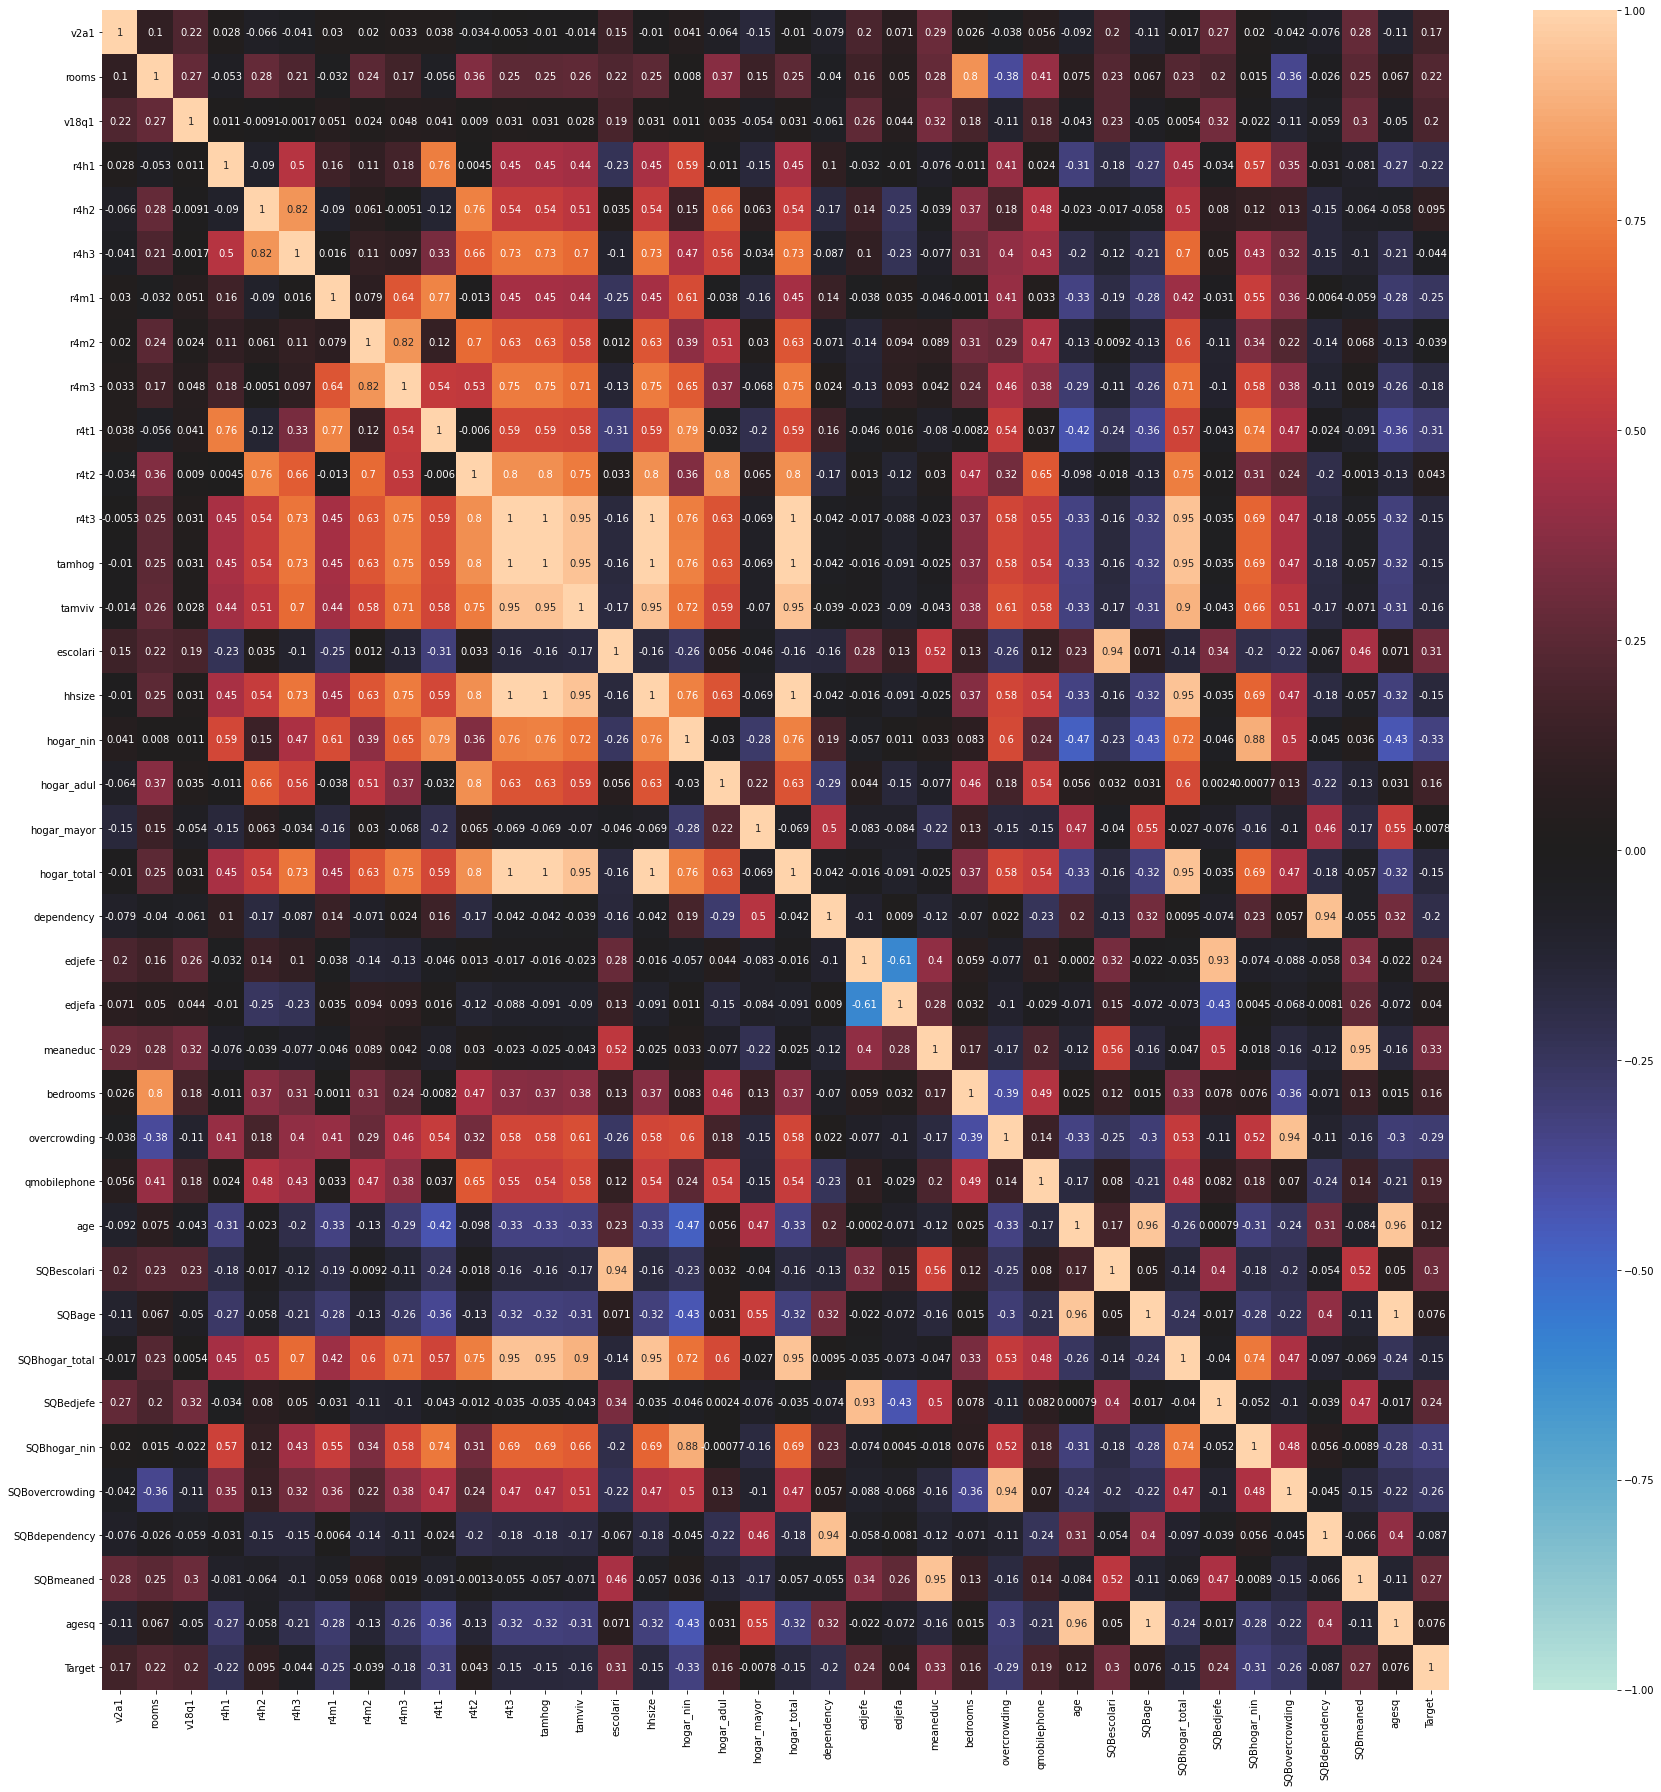

In [65]:
nonBinary_num_cols = train.columns[train.nunique()>2].drop(train.columns[train.apply(np.dtype)=='object'])

fig,ax = plt.subplots(figsize=(25,25))
sns.heatmap(data_corr.loc[nonBinary_num_cols,nonBinary_num_cols],vmax=1,vmin=-1,annot=True,cmap=sns.color_palette("icefire", as_cmap=True))
fig.tight_layout()

In [66]:
data_corr.iloc[:-1,-1][(data_corr.iloc[:-1,-1]>0.5) | (data_corr.iloc[:-1,-1]<-0.5)]

Series([], Name: Target, dtype: float64)

- No individual feature/column seem to be correlated enough with the 'Target' label.

In [67]:
feat_corr = {}
for i,x in enumerate(data_corr.columns):
  for j,y in enumerate(data_corr.index):
      if (j>i and (data_corr[x][y]>0.7 or data_corr[x][y]<-0.7) ):
        feat_corr.update({f'{x} - {y}':data_corr[x][y]})

feat_corr_ordered = sorted(feat_corr.items(), key=(lambda item: item[1]),reverse=True)

for x in feat_corr_ordered:
  print(f"'{x[0]}'  : ",x[1])

'tamhog - hhsize'  :  1.0
'tamhog - hogar_total'  :  1.0
'hhsize - hogar_total'  :  1.0
'SQBage - agesq'  :  1.0
'r4t3 - tamhog'  :  0.9985001241441968
'r4t3 - hhsize'  :  0.9985001241441968
'r4t3 - hogar_total'  :  0.9985001241441968
'age - SQBage'  :  0.9578050313700165
'age - agesq'  :  0.9578050313700165
'tamhog - SQBhogar_total'  :  0.9498918102971264
'hhsize - SQBhogar_total'  :  0.9498918102971264
'hogar_total - SQBhogar_total'  :  0.9498918102971264
'r4t3 - SQBhogar_total'  :  0.9485902653414167
'meaneduc - SQBmeaned'  :  0.947533744838704
'r4t3 - tamviv'  :  0.947393515334684
'tamhog - tamviv'  :  0.9461224079562398
'tamviv - hhsize'  :  0.9461224079562398
'tamviv - hogar_total'  :  0.9461224079562398
'overcrowding - SQBovercrowding'  :  0.9446796261512629
'escolari - SQBescolari'  :  0.9429040584569114
'dependency - SQBdependency'  :  0.9427064008745315
'edjefe - SQBedjefe'  :  0.9336652280391996
'tamviv - SQBhogar_total'  :  0.9036448045195464
'hogar_nin - SQBhogar_nin'  :  

- We have alot of columns that are highly correlated with each other, mostly signifying redundent information for model training.

In [68]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler

ohe = OneHotEncoder(handle_unknown='ignore')
le = LabelEncoder()
scaler = StandardScaler()

In [69]:
from sklearn.compose import ColumnTransformer

In [70]:
num_attribs = train.columns.drop(['Target','idhogar'])
#num_attribs = train.columns.drop(['idhogar'])
cat_attribs = ['idhogar']
label_attribs = 'Target'

In [71]:
class ModifiedLabelEncoder(LabelEncoder):

  def fit_transform(self,y,*args, **kwargs):
    return super().fit_transform(y).reshape(-1,1)

  def transform(self,y,*args, **kwargs):
    return super().transform(y).reshape(-1,1)

In [72]:
data_transformers = ColumnTransformer([
                                       ('std_scaler',scaler,num_attribs),
                                       ('oh_encoder',ohe,cat_attribs),
                                       ('lbl_encoder',ModifiedLabelEncoder(),label_attribs),
                                       #('lbl_encoder',le,y)
])

In [73]:
train_final = data_transformers.fit_transform(train)
train_final

<7640x3015 sparse matrix of type '<class 'numpy.float64'>'
	with 1068996 stored elements in Compressed Sparse Row format>

In [74]:
X_train = train_final[:,:-1]
y_train = np.asarray(train_final[:,-1].todense()).ravel()

We could also create Custom Transformer and integrate it with other data transformations using Pipeline.

In [75]:
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.pipeline import Pipeline

In [76]:
class HandlingMissingValues(TransformerMixin,BaseEstimator):

  def __init__(self):
    self
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    X.loc[:,['v2a1']] = X.v2a1.fillna(0)
    X.loc[:,['v18q1']] = X.v18q1.fillna(0)
    X = X.drop(columns='rez_esc')
    X = X.dropna()
    X.loc[:,'dependency'] = X.dependency.replace({'yes':1,'no':0})
    X.loc[:,'dependency'] = X.loc[:,'dependency'].astype('float')
    X.loc[:,['edjefe','edjefa']] = X.loc[:,['edjefe','edjefa']].replace({'yes':1,'no':0})
    X.loc[:,['edjefe','edjefa']] = X.loc[:,['edjefe','edjefa']].astype('int')
    X = X.drop(columns='Id')
    return X

In [77]:
preprocess_pipeline = Pipeline([
          ('missing_vals',HandlingMissingValues()),
          ('data_transformers',data_transformers)
])

In [78]:
train_processed = preprocess_pipeline.fit_transform(train_set)
train_processed

<7640x3015 sparse matrix of type '<class 'numpy.float64'>'
	with 1068996 stored elements in Compressed Sparse Row format>

In [79]:
X_train_fin = train_processed[:,:-1]
y_train_fin = np.asarray(train_processed[:,-1].todense()).ravel()
y_train_fin

array([3., 3., 2., ..., 3., 1., 0.])

In [80]:
from sklearn.ensemble import RandomForestClassifier

In [81]:
from sklearn.metrics import roc_auc_score,classification_report,plot_confusion_matrix,SCORERS,accuracy_score
from sklearn.model_selection import cross_val_score

In [82]:
!pip install -q optuna

In [83]:
import optuna

In [84]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_fin,y_train_fin)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [85]:
def objective_rfc(trial):

  max_depth=trial.suggest_int('max_depth',3,31,step=2)
  min_samples_leaf=trial.suggest_int('min_samples_leaf',1,51,step=5)
  n_estimators=trial.suggest_int('n_estimators',30,120,step=2)
  max_features=trial.suggest_float('max_features',0.5,1,step=0.05)
  
  clf = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf ,n_estimators=n_estimators, max_features=max_features, class_weight='balanced_subsample',random_state=21)
  
  return cross_val_score(clf,X_train_fin,y_train_fin,scoring='balanced_accuracy', cv=3, n_jobs=-1).mean()

In [86]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_rfc,20)

best_trial = study.best_trial

[I 2021-07-19 14:38:41,812] A new study created in memory with name: no-name-eb380c63-f2e2-42fb-92d5-2820292a4d9b
[I 2021-07-19 14:39:21,047] Trial 0 finished with value: 0.6882605517492877 and parameters: {'max_depth': 9, 'min_samples_leaf': 11, 'n_estimators': 74, 'max_features': 0.65}. Best is trial 0 with value: 0.6882605517492877.
[I 2021-07-19 14:39:57,620] Trial 1 finished with value: 0.5944282891484577 and parameters: {'max_depth': 7, 'min_samples_leaf': 26, 'n_estimators': 104, 'max_features': 0.75}. Best is trial 0 with value: 0.6882605517492877.
[I 2021-07-19 14:40:42,375] Trial 2 finished with value: 0.698526960676098 and parameters: {'max_depth': 17, 'min_samples_leaf': 16, 'n_estimators': 72, 'max_features': 0.65}. Best is trial 2 with value: 0.698526960676098.
[I 2021-07-19 14:41:23,598] Trial 3 finished with value: 0.6272929709261738 and parameters: {'max_depth': 25, 'min_samples_leaf': 31, 'n_estimators': 76, 'max_features': 0.9}. Best is trial 2 with value: 0.69852696

In [87]:
best_trial.params

{'max_depth': 31,
 'max_features': 0.8500000000000001,
 'min_samples_leaf': 1,
 'n_estimators': 120}

In [88]:
best_trial.value

0.8468767573872551

In [89]:
rf_clf = RandomForestClassifier(**best_trial.params, class_weight='balanced_subsample',random_state=21)
rf_clf.fit(X_train_fin,y_train_fin)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=31, max_features=0.8500000000000001,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=None, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

In [90]:
missing_count(test)

Number of Instances :  1912
Number of Missing Values in :
  - v2a1 : 1401 (73.27 %)
  - v18q1 : 1447 (75.68 %)
  - rez_esc : 1582 (82.74 %)


In [91]:
test_processed = preprocess_pipeline.transform(test)
test_processed

<1912x3015 sparse matrix of type '<class 'numpy.float64'>'
	with 267373 stored elements in Compressed Sparse Row format>

In [92]:
X_test_fin = test_processed[:,:-1]
y_test_fin = (test_processed[:,-1].todense())

In [93]:
y_pred = rf_clf.predict(X_test_fin)
print(list(y_pred))

[3.0, 3.0, 3.0, 3.0, 3.0, 1.0, 3.0, 2.0, 3.0, 0.0, 3.0, 1.0, 3.0, 3.0, 2.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 1.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 1.0, 2.0, 3.0, 3.0, 3.0, 1.0, 3.0, 3.0, 3.0, 1.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 1.0, 1.0, 3.0, 3.0, 3.0, 1.0, 3.0, 2.0, 1.0, 3.0, 3.0, 0.0, 2.0, 3.0, 3.0, 1.0, 3.0, 2.0, 2.0, 1.0, 3.0, 3.0, 3.0, 1.0, 0.0, 1.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 2.0, 3.0, 3.0, 2.0, 3.0, 3.0, 2.0, 1.0, 3.0, 3.0, 3.0, 2.0, 3.0, 1.0, 0.0, 2.0, 0.0, 3.0, 0.0, 3.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 1.0, 2.0, 3.0, 2.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 1.0, 3.0, 3.0, 2.0, 2.0, 0.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 0.0, 1.0, 2.0, 1.0, 3.0, 1.0, 3.0, 1.0, 3.0, 2.0, 3.0, 3.0, 3.0, 1.0, 0.0, 3.0, 1.0, 3.0, 0.0, 1.0, 2.0, 0.0, 3.0, 3.0, 1.0, 3.0, 0.0, 3.0, 0.0, 3.0, 3.0, 3.0, 3.0, 1.0, 3.0, 3.0, 3.0, 1.0, 3.0, 1.0,

In [94]:
y_pred_proba = rf_clf.predict_proba(X_test_fin)
print(y_pred_proba)

[[1.66666667e-02 1.45091560e-04 2.50550861e-02 9.58133156e-01]
 [1.66666667e-02 5.83333333e-02 1.08333333e-01 8.16666667e-01]
 [0.00000000e+00 8.49564659e-03 1.68059324e-02 9.74698421e-01]
 ...
 [2.47675122e-02 0.00000000e+00 0.00000000e+00 9.75232488e-01]
 [0.00000000e+00 8.35574474e-03 1.66666667e-02 9.74977589e-01]
 [0.00000000e+00 8.48985569e-03 8.59264340e-03 9.82917501e-01]]


In [95]:
print(classification_report(y_test_fin,y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.93       151
         1.0       0.94      0.94      0.94       319
         2.0       0.93      0.90      0.91       242
         3.0       0.97      0.99      0.98      1200

    accuracy                           0.96      1912
   macro avg       0.96      0.93      0.94      1912
weighted avg       0.96      0.96      0.96      1912



- We are getting a good F1-Score for all the classes with the least being 0.91
- The least Precision and Recall among all the classes are 0.93 and 0.89 respectively.

In [101]:
roc_auc_score(np.asarray(y_test_fin).ravel(),y_pred_proba,multi_class='ovr', average='weighted')

0.992505894428734

- We are getting an ROC-AUC score of 0.99 which is very good.

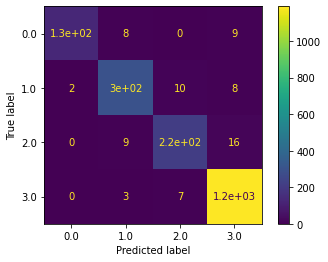

In [102]:
plot_confusion_matrix(rf_clf,X_test_fin,y_test_fin)

In [103]:
accuracy_score(y_test_fin,y_pred)

0.9623430962343096

- There are very few misclassifications as observed from the confusion-matrix.
- We are getting an overall accuracy of 96.2% 

On the overall, we can conclude that the modelled Random Forest Classifier is very efficient in classifying the Income Qualification for the given dataset.